## learning-AI : EMG EDA and CNN-LSTM을 통한 classification (retry)
### EMG Physical Action Data Set 논문 분석 및 탐색적 데이터 분석, CNN-LSTM을 통한 classification

<br>

- **임규연 (lky473736)**
- 2024.09.25.에 문서 수정
- **dataset** : https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
- **data abstract** : The Physical Action Data Set includes 10 normal and 10 aggressive physical actions that measure the human activity. The data have been collected by 4 subjects using the Delsys EMG wireless apparatus.

------



## <span id='dl'><mark>DL</mark></span>
    
EMG Physical Action Data Set을 논문에서 주장하는 CNN-LSTM으로 구현해본다.

- **Reference**
    - https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
    - https://www.ucihealth.org/health-library/content?contentTypeID=92&contentID=P07656&language=en
    - https://www.kaggle.com/code/durgancegaur/emg-dataset
    - https://www.kaggle.com/code/rachit2702/notebook6db9079b5a
    - https://ieeexplore.ieee.org/document/10288050/references#references
    - https://medium.com/analytics-vidhya/analysis-of-emg-physical-data-aggressive-normal-activities-4d5a696730b4
    

In [139]:
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

----

### 이전 experiment 결과 요약 및 앞으로의 classification 전략

이전 experiment 문서인 ```./EDA_CNN-LSTM_classification_EMG```에서 두 가지 모델을 만들었고 그에 대한 정리는 다음과 같다.

첫 번째 모델은 2-branch model structure로, https://www.kaggle.com/code/durgancegaur/emg-dataset/notebook 에서 작성된 노트북 파일에서 아이디어를 얻었다. 논문에서 구현하였던 방식과는 조금 차이가 있지만 각각의 dataset을 한꺼번에 넣고 학습하니 분류능력이 더욱 뛰어나게 성장하는 방향으로 fitting을 진행할 줄 알았다. **위 figure에서 왼쪽 branch는 Normal set을 학습시키고, 오른쪽 branch는 Aggressive set을 학습시킨다. Concatenate 층에서 둘을 병합한 후 Dense를 이용하여 classification하는 구조**이다. 각 set마다의 branch를 만든 것이며, 각각의 branch에 순환 신경망인 LSTM을 n개씩 배치하여 논문에서 주장하고 있는 바를 확인하려고 하였었다.

하지만, 이가 잘못되었다는 사실은 아래 두 가지 근거를 생각하면서 알아차렸다.

- **normal set과 aggressive set을 각각의 branch를 통하여 입력하였으나, 이러면 당연히 shape가 맞지 않다.**
    - 원래 기대하였던 target의 갯수는 (98886, 8, 1) (98172, 8, 1)을 대입하였으니 $ 98886 + 98172 == 197058$이 되어야 한다. 하지만 두 set 중 크기가 작은 것은 oversampling하여 두 set의 batch 크기가 98886으로 같아졌을 것이고, 그러면 **출력 결과 또한 98886개**가 된다. 
- **두 set을 동시에 입력하여 좋은 점이 무엇이 있을까?**
    - 특정 데이터를 병렬로 학습하는 것도 아닐 뿐더러, branch에 대입한 두 데이터셋을 통하여 normal이냐, aggressive냐 라고 이진분류하는 것도 아니다.
    - <s>**현 상황에서 branch를 나누어 input하고 싶다면 차라리 각 행동별로 총 20개의 input branch를 통하여 대입하는 것이 훨씬 현명한 방법이다.**</s>
    
<br>

<img src="https://www.researchgate.net/publication/369583935/figure/fig3/AS:11431281131173230@1680038764730/Hybrid-LSTM-and-dense-deep-learning-layers-for-EMG-signals-with-8-channels-input-LSTM.png" width="500px">

- https://www.researchgate.net/publication/369583935_A_Hybrid_Stacked_CNN_and_Residual_Feedback_GMDH-LSTM_Deep_Learning_Model_for_Stroke_Prediction_Applied_on_Mobile_AI_Smart_Hospital_Platform?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6Il9kaXJlY3QifX0
    
위 주장 중 ```현 상황에서 branch를 나누어 input하고 싶다면 차라리 각 행동별로 총 20개의 input branch를 통하여 대입하는 것이 훨씬 현명한 방법이다.```는 잘못된 생각이었다. 위 figure를 보자. 위 figure은 신체에 EMG 센서링을 총 8개 특성으로 구성하고 있으므로, branch의 갯수가 특성의 갯수여야 한다는 것이다. 따라서 branch를 나누고 싶으면 차라리 **feature의 갯수인 총 8개의 input branch**를 구성해야 한다는 것이다.



<br>

따라서 두 번째 모델에서는 논문에서 언급하고 있는 모델 그대로를 구현하도록 노력하였다. 아래 implementation figure처럼 말이다.

```
<Conv1D (conv1d_9)  ──▶  BatchNormalization (batch_normalization_3)  ──▶  Dropout (dropout_13)>
     │                                                                 
     ▼                                                                 
<Conv1D (conv1d_10) ──▶ BatchNormalization (batch_normalization_4)  ──▶ Dropout (dropout_14)>
     │                                                                 
     ▼                                                                 
<Conv1D (conv1d_11) ──▶ BatchNormalization (batch_normalization_5)  ──▶ Dropout (dropout_15)>
     │                                                                 
     ▼                                                                 
TimeDistributed (time_distributed_1)
     │
     ▼
LSTM (lstm_3) ──▶ Dropout (dropout_16)
     │
     ▼
Dense (dense_7) ──▶ Dropout (dropout_17)
     │
     ▼
Dense (dense_8) ──▶ Dropout (dropout_18)
     │
     ▼
Dense (dense_9)
```

<img src="./report_fail.png" width="500px">

하지만, 이 또한 정말 좋지 못한 분류 능력을 보여주었고, 위와 같이 특정 영역에서만 f1-score가 등장하는 것을 알 수 있는데, 그마저도 **매우 희박**하다. 추측컨데 다음과 같은 원인으로 위와 같은 결과가 나온 것 같다.

- **데이터 전처리와 데이터 구성 중의 문제**
    - 이전 experiment에서는 각 피실험자의 딕셔너리의 value를 구성하여, **각각의 피실험자의 normal set, aggressive set을 value의 value (dataframe)로 정리하였다.** 하지만 이 과정이 매우 복잡하여, 추후 이와 비슷한 데이터셋을 experiment한다고 할 때 이와 같은 방식을 사용하면 안되겠다고 느꼈다.
    - **모든 파일의 sample의 결측치를 평균값으로 대체하였는데, 사실 그럴 만한 근거가 없다.** 센서 값들이 feature를 이루고 있는 데, 각각의 상황마다 달라지는 feature 값을 평균값으로 대체한다는 것은 납득될 요소가 없다.
- **modeling의 문제**
    - train set의 acc와 val set의 acc가 극명한 폭으로 달라지고 있었으며, val_loss 또한 안정적으로 하강하지 않았었다. 
    - 이 **overfitting** 문제를 해결하기 위해서 아래와 같은 간단한 방법이 있다.
        - (1) **regularization을 추가하는 것**
            - 기존 layer에 l2 규제 비율을 더욱 증가하여 안정적으로 feature 수치를 control하면서 학습될 수 있도록 하여야 할 것임
            - CNN 이후에 dropout 비율을 조금 더 늘려서 신중한 학습 (cautious fitting)을 하도록 유도한다
        - (2) **model의 복잡성을 줄인다**

**디렉토리 구조를 fixing하여 데이터가 정리된 버전이 이 링크에 있다.(https://www.kaggle.com/datasets/durgancegaur/emg-physical-action-data-set/data) 본 experiment에서는 데이터가 정리된 이 버전을 사용한다. hyperparameter tuning을 계속하여 모델의 성능을 전체적으로 upgrade해보자.**

-------

### 파일 열기, 간단한 탐색적 데이터 분석 및 데이터 전처리
- 파일을 열어 구조부터 확인하고, 구조 확인 후 normal set과 aggressive set을 각각 병합하며, 병합이 완료되면 각 record마다 label을 붙인다.
    - 추후에 label encoding하지 않아도 되도록, 0-based로 target을 나타낸다
- 간단한 탐색적 데이터 분석은 아래와 같이 진행한다.
    - target countplot
    - 각 열에 대해 heatmap 그리기, target값과의 상관관계성 파악하기
    - 각 열에 대해 분포 파악 위해 histplot

In [140]:
# 현재 위치 디렉토리 이동 및 ls -lha로 현재 디렉토리 구조 확인

import os

os.system('cd ../../ && cd ./data/EMG/EMG && ls -lha && cd ./sub && ls -lha')

'''
    Aggressive, Normal 폴더 있음
'''

total 32
drwxr-xr-x@ 9 alphastation  staff   288B  9 25 11:15 .
drwxr-xr-x  6 alphastation  staff   192B  9 25 11:06 ..
-rw-r--r--@ 1 alphastation  staff   6.0K  9 25 13:16 .DS_Store
-rw-rw-r--@ 1 alphastation  staff   4.1K  9 12 15:25 readme.txt
drwxr-xr-x@ 5 alphastation  staff   160B  9 25 13:16 sub
drwxr-xr-x@ 4 alphastation  staff   128B  9 25 09:12 sub1
drwxr-xr-x@ 4 alphastation  staff   128B  9 25 09:12 sub2
drwxr-xr-x@ 4 alphastation  staff   128B  9 25 09:12 sub3
drwxr-xr-x@ 4 alphastation  staff   128B  9 25 09:12 sub4
total 16
drwxr-xr-x@  5 alphastation  staff   160B  9 25 13:16 .
drwxr-xr-x@  9 alphastation  staff   288B  9 25 11:15 ..
-rw-r--r--@  1 alphastation  staff   6.0K  9 25 13:16 .DS_Store
drwxr-xr-x@ 12 alphastation  staff   384B  9 25 10:59 Aggressive
drwxr-xr-x@ 12 alphastation  staff   384B  9 25 10:59 Normal


'\n    Aggressive, Normal 폴더 있음\n'

In [141]:
# Aggressive와 Normal 각각에 있는 csv 파일 이름 확인

os.system('cd ../../ && cd ./data/EMG/EMG/sub/Aggressive && ls -lha')
os.system('cd ../../ && cd ./data/EMG/EMG/sub/Normal && ls -lha')

total 11104
drwxr-xr-x@ 12 alphastation  staff   384B  9 25 10:59 .
drwxr-xr-x@  5 alphastation  staff   160B  9 25 13:16 ..
-rw-rw-r--@  1 alphastation  staff   557K 11 24  2022 Elbowing.csv
-rw-rw-r--@  1 alphastation  staff   554K 11 24  2022 Frontkicking.csv
-rw-rw-r--@  1 alphastation  staff   558K 11 24  2022 Hamering.csv
-rw-rw-r--@  1 alphastation  staff   535K 11 24  2022 Headering.csv
-rw-rw-r--@  1 alphastation  staff   536K 11 24  2022 Kneeing.csv
-rw-rw-r--@  1 alphastation  staff   558K 11 24  2022 Pulling.csv
-rw-rw-r--@  1 alphastation  staff   563K 11 24  2022 Punching.csv
-rw-rw-r--@  1 alphastation  staff   556K 11 24  2022 Pushing.csv
-rw-rw-r--@  1 alphastation  staff   558K 11 24  2022 Sidekicking.csv
-rw-rw-r--@  1 alphastation  staff   555K 11 24  2022 Slapping.csv
total 10168
drwxr-xr-x@ 12 alphastation  staff   384B  9 25 10:59 .
drwxr-xr-x@  5 alphastation  staff   160B  9 25 13:16 ..
-rw-rw-r--@  1 alphastation  staff   513K 11 24  2022 Bowing.csv
-rw-rw-r--

0

In [142]:
# 위 파일 중 Normal/Running.csv 중 20줄만 출력

with open('../../data/EMG/EMG/sub/Normal/Running.csv', 'r') as file :
    for i, line in enumerate(file) :
        if i == 20 : # 20줄만 출력하기
            break
            
        print (line.strip())  

0,1,2,3,4,5,6,7,label
-10.75,-27.75,438.5,-125.75,1768.75,-2296.5,-1435.0,-180.75,5
88.0,-81.75,617.25,-235.25,1819.0,-2171.75,-1375.0,-324.5,5
184.25,-121.75,583.5,-380.0,1997.0,-1670.5,-1587.5,-267.5,5
134.0,-130.25,276.5,-322.75,1830.5,-1523.0,-1424.5,-284.5,5
-85.75,-75.25,-4.75,-316.5,1631.0,-1471.75,-1277.75,-521.75,5
-222.5,-31.0,-248.25,-159.25,1845.5,-1216.25,-1138.5,-804.5,5
-237.25,-35.0,-386.5,-13.75,1825.5,-1155.0,-990.5,-905.0,5
-135.75,-18.0,-407.25,-62.25,1714.0,-958.5,-1002.25,-834.5,5
85.75,-9.25,-559.5,-115.25,2152.25,-634.5,-942.5,-844.5,5
348.75,-52.25,-404.75,-165.0,2144.0,-554.5,-451.25,-753.5,5
481.5,-49.0,109.25,-233.0,2265.75,-665.75,6.0,-820.0,5
703.0,-98.25,172.25,-234.0,2840.5,-553.0,235.25,-1045.0,5
786.5,-159.75,-255.25,-192.5,2732.25,-690.25,429.0,-1112.5,5
562.5,-117.0,-549.75,-210.25,2086.0,-746.5,616.5,-1246.75,5
453.5,-99.25,-721.0,-167.0,1646.5,-574.0,869.25,-1388.25,5
350.75,-52.25,-714.5,-23.0,1288.75,-365.75,918.0,-1080.75,5
286.75,-36.75,-667.75

기존 파일인 ```../../data/EMG/EMG/sub1/Normal/txt/Running.txt```의 20줄만 확인해보면 아래와 같이 출력되었다.

```
131	-91	2018	-75	4000	-4000	-1999	267
93	-233	2917	-78	4000	-4000	-2549	251
100	-369	3007	-84	4000	-4000	-4000	195
-108	-399	1770	-86	3232	-4000	-4000	186
-342	-192	815	-63	2759	-4000	-4000	140
-420	-4	-17	-22	2581	-4000	-4000	76
-473	40	-523	63	2386	-4000	-4000	154
-323	78	-317	124	1994	-4000	-4000	239
-91	139	-761	105	1669	-4000	-3637	241
107	56	-107	79	1971	-3848	-1684	296
334	0	2093	-105	2101	-3643	238	131
487	21	2095	-216	2101	-3405	1353	-450
537	-37	-146	-251	1850	-3144	2036	-909
281	-47	-1554	-359	420	-2895	2760	-1296
245	-55	-2241	-279	-1121	-2612	3754	-1709
277	8	-2318	-133	-2436	-2382	4000	-1831
102	98	-2497	-40	-4000	-2095	4000	-1911
-84	180	-2342	94	-4000	-1755	4000	-1820
-255	225	-1274	154	-3387	-1375	4000	-1204
-286	172	457	121	-1703	-875	4000	-419
```

기존에는 sub1, sub2, sub3, sub4의 폴더를 열었을 때 모든 데이터 파일의 확장자가 txt이였으며, os 라이브러리의 이름 변경 모듈 및 사용자 권한 수정으로 인한 에러 처리까지 함께 진행하여야 했었다. 또한 각 column에 대하여 attribute명이 지정되어 있지 않아 ["R-Bic", "R-Tri", "R-Thi", "R-Ham", "L-Bic", "L-Tri", "L-Thi", "L-Ham"]으로 두는 코드를 작성하였다. 하지만 **현재 sub 하위 파일은 모두 csv로 처리되어 있으며 각각의 attribute 명을 0, 1, 2, 3 ...으로 구성하였다. 심지어는 각 행동마다 target 열까지 추가하여 data split이 편하도록 구성하였다. 위 /sub 하위 파일들을 병합하여 dataset을 구성하겠다.**

In [143]:
# 각 csv 파일의 첫번째~두번째 라인만 출력해보기 -> mapping table 구성

# 경로 설정
aggressive_dir = "../../data/EMG/EMG/sub/Aggressive"
normal_dir = "../../data/EMG/EMG/sub/Normal"

# mapping table of target
behaviors = dict()

normal_files = [f for f in os.listdir(normal_dir) if f.endswith('.csv')]
for file in normal_files:
    file_path = os.path.join(normal_dir, file)
    df = pd.read_csv(file_path, nrows=2)  
    print(f"file name : {file}")
    print(df)
    print("\n")
    behaviors[file[:file.index('.')]] = int(df.iloc[0]['label'])

aggressive_files = [f for f in os.listdir(aggressive_dir) if f.endswith('.csv')]
for file in aggressive_files:
    file_path = os.path.join(aggressive_dir, file)
    df = pd.read_csv(file_path, nrows=2) 
    print(f"file name : {file}")
    print(df)
    print("\n")
    behaviors[file[:file.index('.')]] = int(df.iloc[0]['label']) + 10 

'''
    확인해보니 aggressive set은 10부터 시작하는 것이 아닌 Normal set과 마찬가지로 0부터 시작함
    따라서 중복 방지를 위해 aggressive의 class는 10부터 구성하도록 함
'''

print (normal_files)
print (aggressive_files)
behaviors = dict(sorted(behaviors.items(), key=lambda item: item[1]))
for key in behaviors : 
    print (f"{key}{' '*(16-len(key))}{behaviors[key]}")

file name : Running.csv
       0      1       2       3        4        5       6       7  label
0 -10.75 -27.75  438.50 -125.75  1768.75 -2296.50 -1435.0 -180.75      5
1  88.00 -81.75  617.25 -235.25  1819.00 -2171.75 -1375.0 -324.50      5


file name : Clapping.csv
       0      1       2      3       4     5      6      7  label
0 -71.00 -63.75 -472.25 -48.25  135.75 -41.0 -33.25 -89.25      1
1 -57.75 -44.50 -589.25 -64.25  129.75 -46.0 -47.00 -85.00      1


file name : Jumping.csv
        0       1       2       3       4        5        6        7  label
0  579.75 -165.50  675.75   -9.25  1494.0  1012.75  2400.75 -1712.25      4
1  346.25 -322.75 -200.75 -243.25  -114.0   845.25  2386.75 -1694.75      4


file name : Handshaking.csv
        0      1      2      3       4      5      6      7  label
0  874.50  27.75  25.50  -84.0  306.75  15.75  -4.25  -4.50      2
1  346.75  24.25  -4.25 -110.0  284.00  26.25 -14.75  13.25      2


file name : Seating.csv
      0     1      2 

따라서 mapping table은 아래와 같이 구성된다.

```

behaviors = [
    # Normal
    "Bowing",        # -> 0
    "Clapping",      # -> 1
    "Handshaking",   # -> 2
    "Hugging",       # -> 3
    "Jumping",       # -> 4
    "Running",       # -> 5
    "Seating",       # -> 6
    "Standing",      # -> 7
    "Walking",       # -> 8
    "Waving"         # -> 9
    # Aggressive
    "Elbowing",      # -> 10
    "Frontkicking",  # -> 11
    "Hamering",      # -> 12
    "Headering",     # -> 13
    "Kneeing",       # -> 14
    "Pulling",       # -> 15
    "Punching",      # -> 16
    "Pushing",       # -> 17
    "Sidekicking",   # -> 18
    "Slapping",      # -> 19
] 
```

In [144]:
# sub 아래 모든 csv 파일을 찾아 행 기준으로 병합한다


'''
    모든 records를 학습하는 것이 좋겠지만, 학습 시간이 기하급수적으로 증가하여 앞쪽 3000개 샘플만 가져온다
'''

# Normal
normal_dfs = []

for i, name in enumerate(['Bowing.csv', 'Clapping.csv', 
                         'Handshaking.csv', 'Hugging.csv', 
                         'Jumping.csv', 'Running.csv', 
                         'Seating.csv', 'Standing.csv', 
                         'Walking.csv', 'Waving.csv']) :  
    temp_df = pd.read_csv(os.path.join(normal_dir, name), nrows=3000)
    normal_dfs.append(temp_df)
    
normal_df = pd.concat(normal_dfs, ignore_index=True)

# Aggressive
aggressive_dfs = []

for i, name in enumerate(['Elbowing.csv', 'Frontkicking.csv', 
             'Hamering.csv', 'Headering.csv', 
             'Kneeing.csv', 'Pulling.csv', 
             'Punching.csv', 'Pushing.csv', 
             'Sidekicking.csv', 'Slapping.csv']) :  # label에 10씩 더해주기 (중복 방지)
    temp_df = pd.read_csv(os.path.join(aggressive_dir, name), nrows=3000) 
    temp_df['label'] += 10
    aggressive_dfs.append(temp_df)
    
aggressive_df = pd.concat(aggressive_dfs, ignore_index=True)

df = pd.concat([normal_df, aggressive_df], ignore_index=True)
df.columns = ["R-Bic", "R-Tri", "R-Thi", "R-Ham", "L-Bic", "L-Tri", "L-Thi", "L-Ham", "target"]

df.head(20)

,R-Bic,R-Tri,R-Thi,R-Ham,L-Bic,L-Tri,L-Thi,L-Ham,target
0,-150.25,-177.75,-40.25,30.75,605.25,-72.75,158.75,75.00,0
1,-97.25,-287.00,-41.00,59.00,545.50,-25.25,183.50,23.00,0
2,-240.25,-307.25,-25.25,166.75,485.50,47.25,296.50,74.00,0
3,-169.00,-323.25,-54.00,70.50,191.75,33.25,298.25,95.00,0
4,-125.25,-131.25,-58.25,195.50,449.75,81.25,306.75,8.50,0
5,-144.75,35.75,-60.00,150.00,147.75,57.75,191.75,53.75,0
6,99.00,70.50,-113.25,-182.25,-230.25,10.25,102.50,-107.75,0
7,163.75,148.50,-118.50,-346.00,-308.50,-12.25,105.25,-150.25,0
8,227.25,3.75,-106.25,-413.50,-52.75,-39.50,89.25,-189.50,0
9,121.50,-128.75,-86.00,-256.00,469.50,3.25,65.00,-319.25,0


In [145]:
# info, describe

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R-Bic   60000 non-null  float64
 1   R-Tri   60000 non-null  float64
 2   R-Thi   60000 non-null  float64
 3   R-Ham   60000 non-null  float64
 4   L-Bic   60000 non-null  float64
 5   L-Tri   60000 non-null  float64
 6   L-Thi   60000 non-null  float64
 7   L-Ham   60000 non-null  float64
 8   target  60000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 4.1 MB


,R-Bic,R-Tri,R-Thi,R-Ham,L-Bic,L-Tri,L-Thi,L-Ham,target
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,-19.171246,3.812133,-19.603625,-8.733629,20.435096,30.080092,24.216887,14.590133,9.500000
std,588.492707,394.803665,568.165165,429.294607,967.617401,682.046744,765.057436,755.338950,5.766329
min,-3292.500000,-2903.000000,-3809.750000,-2602.500000,-3963.250000,-3305.750000,-3511.250000,-3720.250000,0.000000
25%,-262.500000,-91.250000,-213.750000,-140.750000,-374.750000,-207.500000,-269.812500,-268.500000,4.750000
50%,-13.000000,4.250000,-8.500000,-15.500000,23.000000,24.500000,22.750000,18.250000,9.500000
75%,223.250000,107.000000,170.750000,105.000000,404.000000,277.750000,322.312500,302.750000,14.250000
max,3129.750000,2742.250000,3159.250000,2581.250000,3979.000000,3384.750000,3556.250000,3529.500000,19.000000


In [146]:
# 결측치 확인 및 결측치 존재하는 record는 제외시킴 

print (df.isnull().sum())
df = df.dropna()
print (df.isnull().sum())

R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64


target
0     3000
1     3000
18    3000
17    3000
16    3000
15    3000
14    3000
13    3000
12    3000
11    3000
10    3000
9     3000
8     3000
7     3000
6     3000
5     3000
4     3000
3     3000
2     3000
19    3000
Name: count, dtype: int64

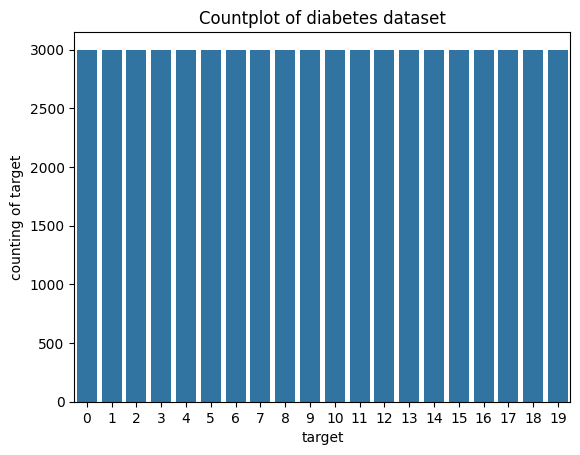

In [147]:
# target 별 counting

sns.countplot(data = df, x="target")
plt.xlabel('target')
plt.ylabel("counting of target")
plt.title('Countplot of diabetes dataset')

df['target'].value_counts()

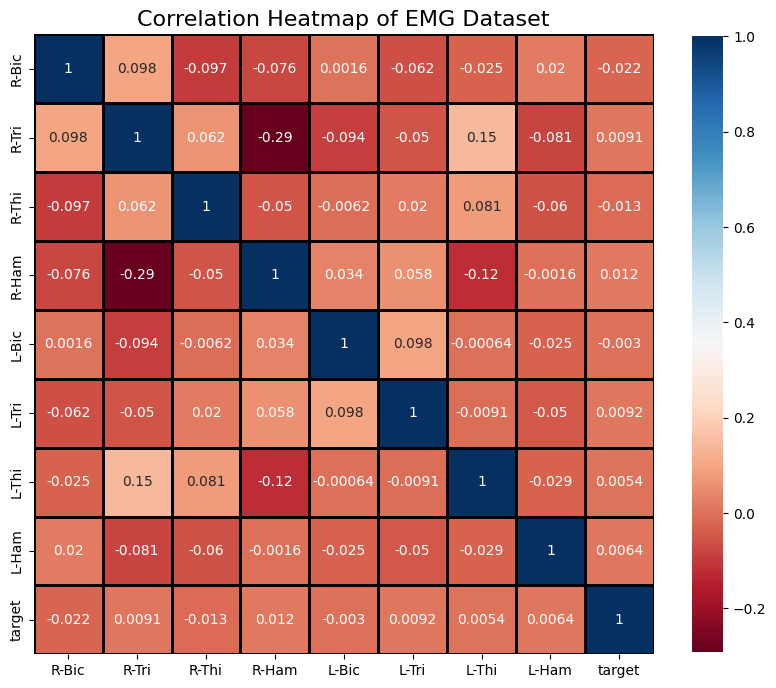

In [148]:
# heatmap

correlation_matrix = df[df.columns].corr() 
plt.figure(figsize=(10, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of EMG Dataset', fontsize=16)
plt.show()

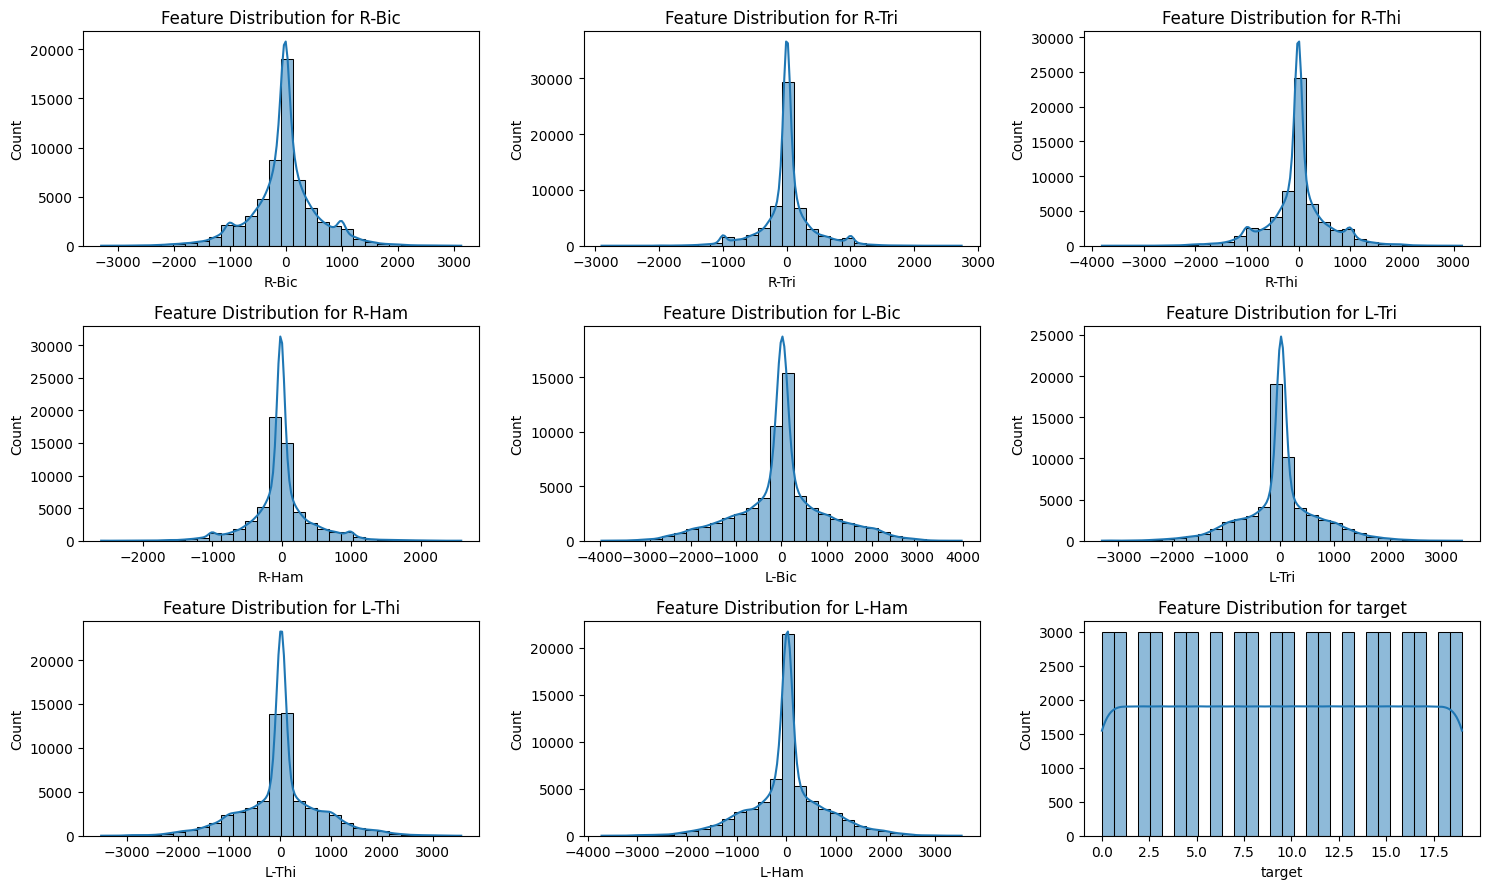

In [149]:
# 각 feature 분포를 plot으로 확인

import math

num_features = len(df.columns) # feature 갯수
num_cols = 3   # 세로
num_rows = math.ceil(num_features / num_cols) # 가로

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten() 

for i, col in enumerate(df.columns) : # 각 col별로 그림 그리기
    if df[col].dtype != 'object' : # 만약 연속형이면 hist
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Feature Distribution for {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

    else : # 범주형이면 count
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_title(f'Feature Distribution for {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

for j in range(i + 1, num_rows * num_cols) :
    fig.delaxes(axes[j]) # 빈 figure는 없애기

plt.tight_layout()
plt.show()

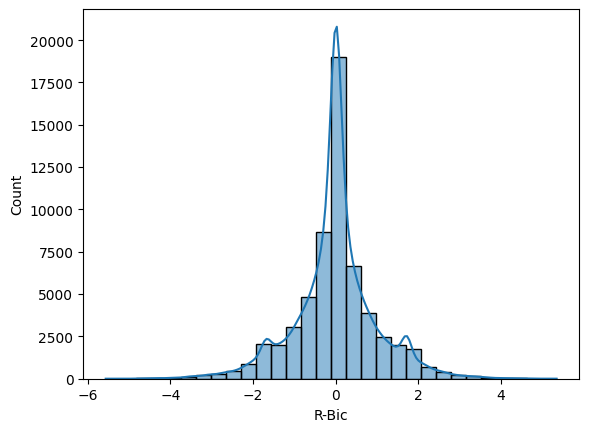

'\n    범위가 기존 -4000~4000보다 훨씬 줄어들음\n'

In [150]:
# normalization

from sklearn.preprocessing import StandardScaler

df_X = df.drop('target', axis=1)
df_y = df['target']

scaler = StandardScaler()
df_X_scaled = scaler.fit_transform(df_X)

df_scaled = pd.DataFrame(np.c_[df_X_scaled, df_y], columns=list(df_X.columns) + ['target'])

# 결과 확인 위해 R-Bic 분포 확인해보기

sns.histplot(df_scaled['R-Bic'], kde=True, bins=30)
plt.show()

'''
    범위가 기존 -4000~4000보다 훨씬 줄어들음
'''

In [151]:
# split_sequence를 frequency를 기준으로 구성

from collections import Counter

def split_sequences_freq(sequences, n_steps):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    for i in range(len(sequences)):
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))

    return np.array(X), np.array(y)

In [152]:
# split_sequence을 이용하여 순환 데이터를 구성

X_seq, y_seq = split_sequences_freq(df_scaled, 
                                    n_steps=50) # window 사이즈를 50으로 구성

print (X_seq.shape, y_seq.shape)

(59951, 50, 8) (59951,)


In [153]:
# 실제로 어떻게 구성되었는지 앞쪽 5개의 component만 출력

print (np.isnan(y_seq).sum())

for idx in range (5) :
    print (f"X_seq[{idx}] : ", X_seq[idx][:5])
    print (f"y_seq[{idx}] : ", y_seq[idx])
    
    if idx == 0 : 
        prev = X_seq[idx]
        print()
        continue

    if (prev[1:] == X_seq[idx][:-1]).all() : 
        '''
            step 1씩 이동했으니깐, 이전 X_train_seq 원소의 2번째 record ~ 마지막번째 record와
            현재 X_train_seq 원소의 첫번째 record ~ 마지막-1번째 record는 같을 수밖에 없습니다.
        '''
         
        print ("window가 step 1씩 이동하면서 순환 데이터를 만듦")
    
    prev = X_seq[idx]
    print()

0
X_seq[0] :  [[-0.22273827 -0.45988339 -0.03633899  0.09197404  0.60439155 -0.15076818
   0.17584854  0.07997783]
 [-0.13267693 -0.73660551 -0.03765904  0.15778021  0.54264142 -0.08112428
   0.20819932  0.01113399]
 [-0.37567262 -0.78789726 -0.00993799  0.40877544  0.48063292  0.0251743
   0.35590188  0.07865391]
 [-0.25459959 -0.82842407 -0.0605399   0.18456856  0.17704966  0.00464768
   0.35818931  0.10645623]
 [-0.1802565  -0.34210234 -0.06802018  0.47574632  0.44368619  0.07502467
   0.36929968 -0.00806285]]
y_seq[0] :  0

X_seq[1] :  [[-0.13267693 -0.73660551 -0.03765904  0.15778021  0.54264142 -0.08112428
   0.20819932  0.01113399]
 [-0.37567262 -0.78789726 -0.00993799  0.40877544  0.48063292  0.0251743
   0.35590188  0.07865391]
 [-0.25459959 -0.82842407 -0.0605399   0.18456856  0.17704966  0.00464768
   0.35818931  0.10645623]
 [-0.1802565  -0.34210234 -0.06802018  0.47574632  0.44368619  0.07502467
   0.36929968 -0.00806285]
 [-0.21339228  0.08089624 -0.0711003   0.36975762  

In [154]:
# train set, test set, val set 구성

from sklearn.model_selection import train_test_split 

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq,
                                           y_seq,
                                           stratify=y_seq,
                                           test_size=0.2)

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(X_train_seq,
                                           y_train_seq,
                                           stratify=y_train_seq,
                                           test_size=0.2)

print ("train : ", X_train_seq.shape, y_train_seq.shape)
print ("test : ", X_test_seq.shape, y_test_seq.shape)
print ("val : ", X_val_seq.shape, y_val_seq.shape)

train :  (38368, 50, 8) (38368,)
test :  (11991, 50, 8) (11991,)
val :  (9592, 50, 8) (9592,)


In [155]:
# one hot encoding

from tensorflow.keras.utils import to_categorical

y_train_seq_encoded = to_categorical(y_train_seq)
y_test_seq_encoded = to_categorical(y_test_seq)
y_val_seq_encoded = to_categorical(y_val_seq)

print(y_train_seq[:5])  
print(y_train_seq_encoded[:5]) 

print(y_test_seq[:5])  
print(y_test_seq_encoded[:5]) 

print(y_val_seq[:5])  
print(y_val_seq_encoded[:5]) 

[11 16  3 11 14]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[12 19  1 10  1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[15 12 11  3 19]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


------


### CNN-LSTM 

<img src="./CNN-LSTM_model.png" width="500px">

- **Reference**
    - https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FArchitecture-of-the-Hybrid-1D-CNN-LSTM-model-for-human-activity-recognition_fig4_343341551&psig=AOvVaw3H4z-wEtr3Asr2SOEydWi3&ust=1727104308517000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCMDRk4fr1ogDFQAAAAAdAAAAABAJ
    - https://www.researchgate.net/figure/The-proposed-CNN-LSTM-model-architecture_fig5_356018554
    
CNN과 LSTM을 결합하여 사용한다. CNN으로 먼저 feature extraction을 진행한 후, LSTM으로 장기 기억 track을 하나 더 두어 순환형 데이터에 맞는 학습을 진행할 것이다. **가능하면 논문에서 언급된 모델과 거의 동일히 구성한다.** 이렇게 학습 시 이점은 아래와 같다고 생각된다.

- 맨 처음에 복잡도를 줄이면 찾아오는 이점
    - 먼저 CNN으로 입력 복잡성을 줄이면 LSTM이 고차원 데이터에 압도되지 않고 순차적 패턴 학습에 집중 가능하다
    - 장기적인 맥락을 유지하고 정보를 오랫동안 기억할 수 있을 것이다.
- CNN-LSTM architecture을 이용하면 영상 분석 및 시계열 분류와 같은 공간적 및 시간적 동력이 주가 되는 training에서 이점을 가져올 것이다. **(예시 : https://github.com/lky473736/learning-AI/blob/main/report/EMG/EDA_CNN-LSTM_classification_EMG.ipynb)**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 49, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 48, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,996 (105.45 KB)

 Trainable params: 26,996 (105.45 KB)

 Non-trainable params: 0 (0.00 B)

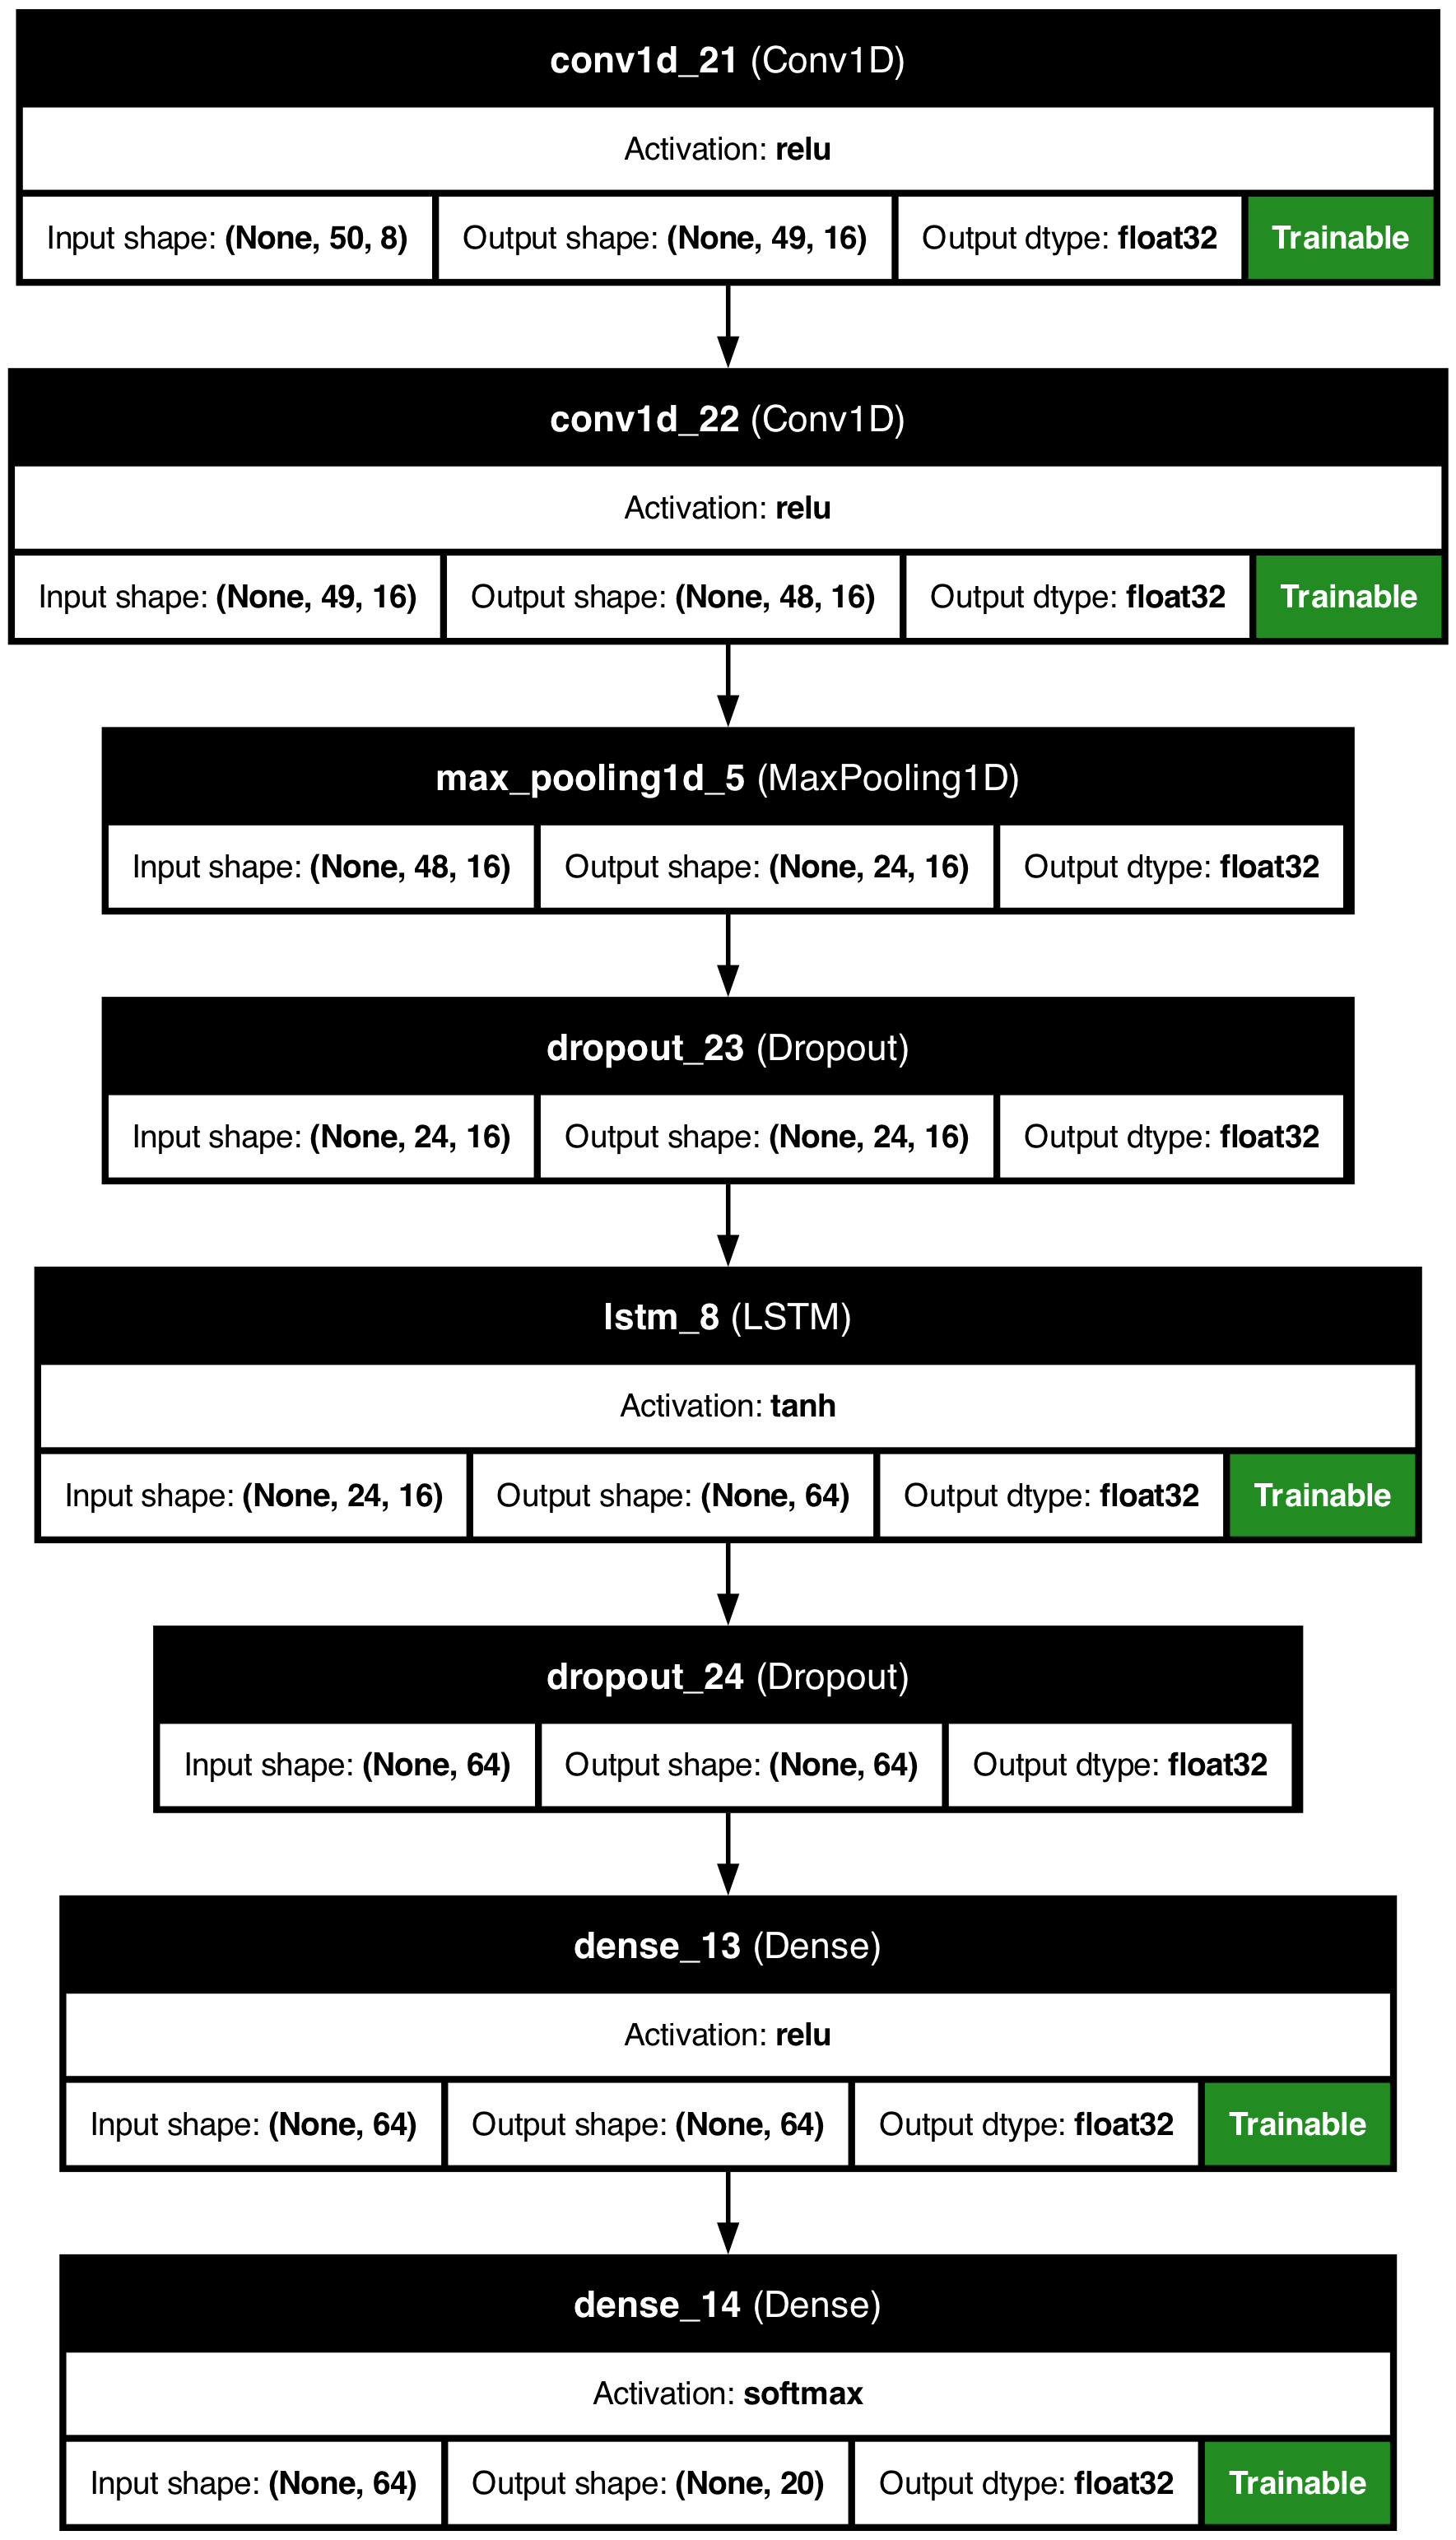

In [156]:
# modeling

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM, Dense, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def make_model(input_shape):
    model = Sequential()
    
    # Spatial Feature Extractor (Conv1D)
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    '''
        TimeDirtributed layer를 구성하려고 하였으나 size error로 인하여 구성 실패
        단순 Conv1D로 실험
    '''
    
    # Temporal Feature Extractor (LSTM after Pooling)
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.1))
    
    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(20, activation='softmax'))  # Assuming 20 classes for classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = make_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
model.summary()

keras.utils.plot_model(model, show_shapes=True, 
                       show_layer_activations=True, 
                       show_dtype=True, show_layer_names=True, 
                       show_trainable=True)


In [157]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=optimizer, 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [158]:
# fit

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(X_train_seq, y_train_seq_encoded, epochs=60, 
                        validation_data=[X_val_seq, y_val_seq_encoded],
                        batch_size=512,
                        callbacks=(early_stopping, 
                                   #reduce_lr,
                                  ), 
                        verbose=True, shuffle=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_72280/3428446429.py
Epoch 1/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.1028 - loss: 2.8012 - val_accuracy: 0.2828 - val_loss: 1.9268
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.3179 - loss: 1.7798 - val_accuracy: 0.4351 - val_loss: 1.3953
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4664 - loss: 1.3626 - val_accuracy: 0.5669 - val_loss: 1.1595
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5605 - loss: 1.1693 - val_accuracy: 0.6062 - val_loss: 1.0114
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6088 - loss: 1.0372 - val_accuracy: 0.6457 - val_loss: 0.9306
Epoch 6/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6400 - loss: 0.9656 - val_accuracy: 0.6819 - val_loss: 0.8422
Epoch 7/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6631 - loss: 0.8974 - val_accuracy: 0.7005 - val_loss: 0.7919
Epoc

Epoch 51/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9639 - loss: 0.1069 - val_accuracy: 0.9927 - val_loss: 0.0289
Epoch 52/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9696 - loss: 0.0943 - val_accuracy: 0.9916 - val_loss: 0.0320
Epoch 53/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9682 - loss: 0.0962 - val_accuracy: 0.9929 - val_loss: 0.0295
Epoch 54/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9701 - loss: 0.0906 - val_accuracy: 0.9924 - val_loss: 0.0277
Epoch 55/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9689 - loss: 0.0950 - val_accuracy: 0.9938 - val_loss: 0.0271
Epoch 56/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9697 - loss: 0.0907 - val_accuracy: 0.9930 - val_loss: 0.0251
Epoch 57/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9709 - loss: 0.0856 - val_accuracy: 0.9940 - val_loss: 0.0231
Epoch 58/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9696 - loss: 0.0883 - val_accuracy: 0.

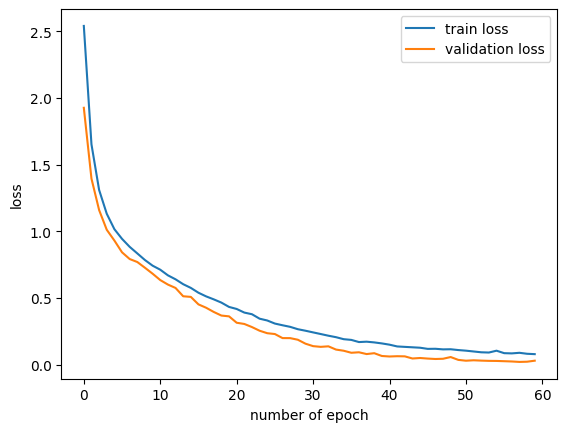

In [159]:
# loss 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

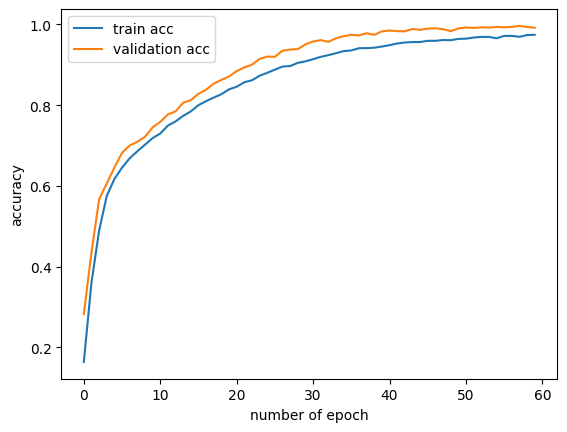

In [160]:
# acc 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train acc', 'validation acc'])
plt.show()

In [162]:
# confusion matrix and classification report

from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = model.predict(X_test_seq)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

cm_test = confusion_matrix(y_test_seq, y_test_pred_classes)
print("- test data confusion matrix -\n")
print(cm_test)

print('\n --------------- \n')

cr_test = classification_report(y_test_seq, y_test_pred_classes)
print("- test data report of classification -\n")
print(cr_test)

print('\n --------------- \n')

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
- test data confusion matrix -

[[596   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 598   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 600   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0 600   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0 598   0   0   0   0   0   0   0   0   0   1   0   1   0
    0   0]
 [  0   0   0   0   0 599   0   0   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   0   0 600   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0 600   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0 600   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   4   0   0   0   0   0   0 596   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 599   0   1   0   0   0   0   0
   

<Axes: >

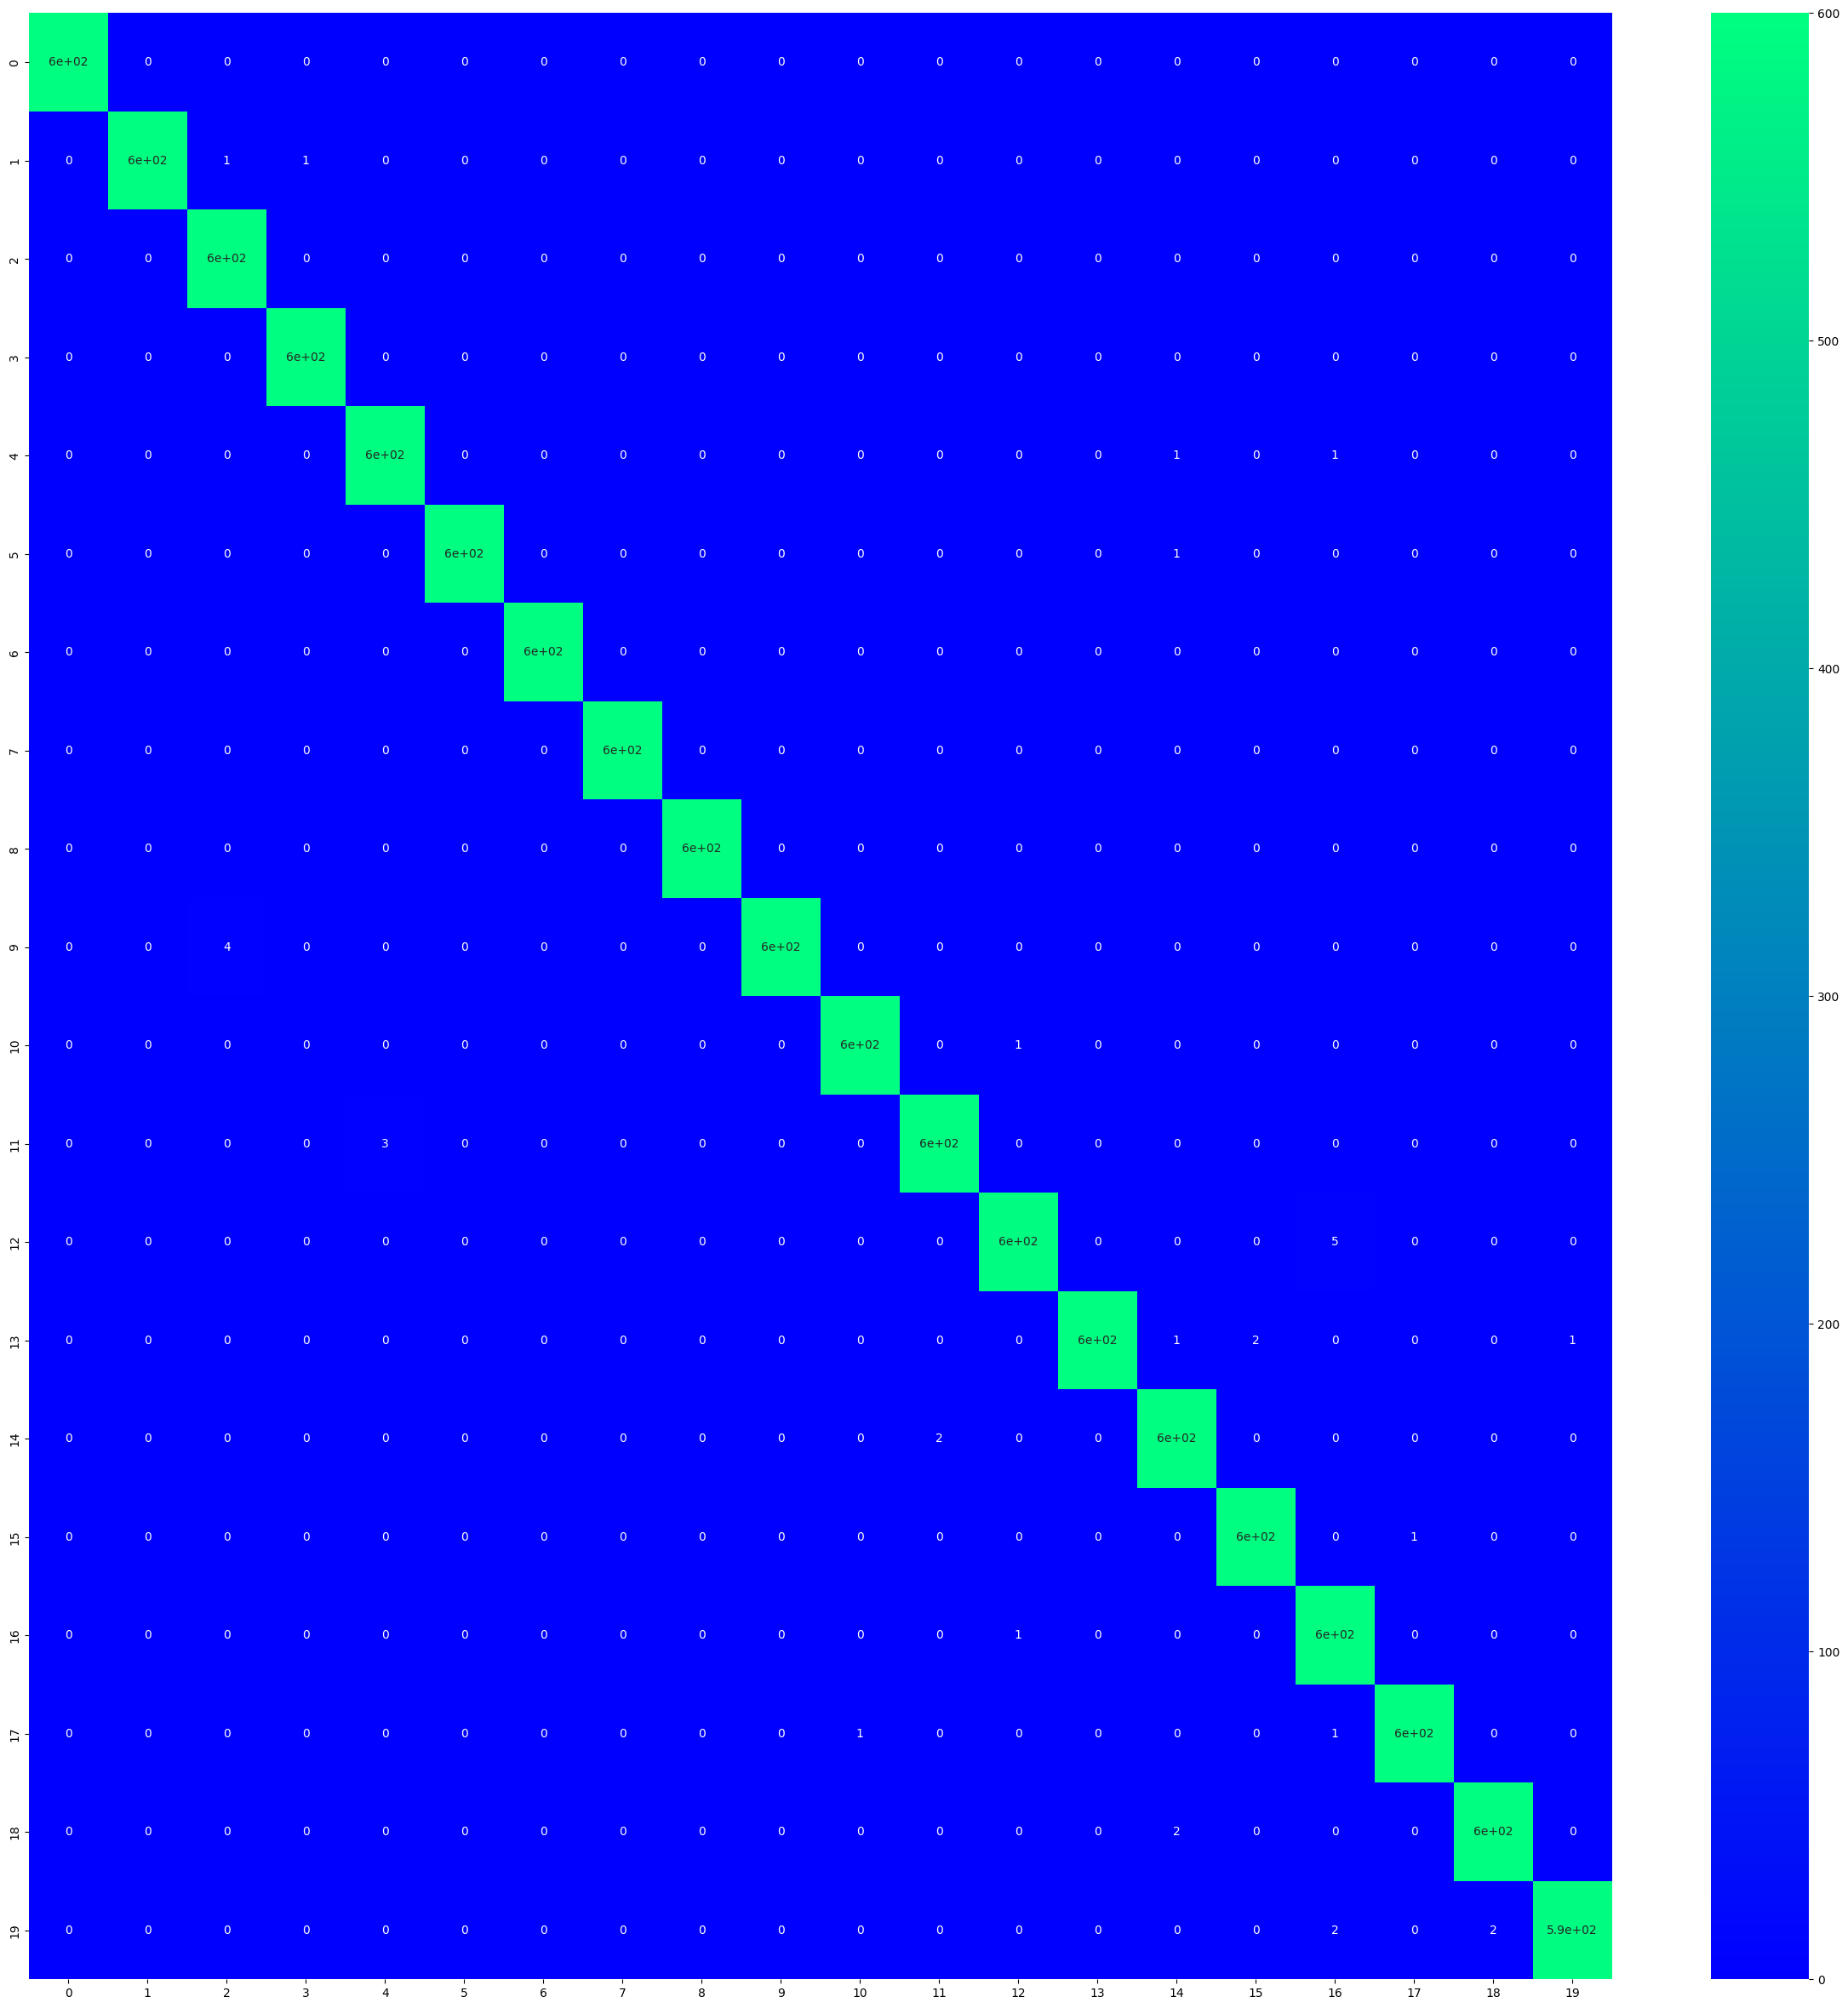

In [167]:
# heatmap으로 confusion matrix 시각화

plt.figure(figsize=(30, 30))
sns.heatmap(cm_test, cmap='winter',
           annot=True)